- current state: $x$, 现状
- proposal: $x+\epsilon$
    - 随机游走（Random Walk）。 下一个点 proposal_x 的生成，完全只依赖于 current_x。它不关心你是从哪儿来的，只关心你现在在哪。
- acceptance: $\frac{P_{new}}{P_{old}}$
- 如下的代码
    - $f(x)$ (target distribution) 并不是一个严格的 pdf，积分未必为1，在贝叶斯统计或复杂的物理计算中，要算那个让积分等于1的分母（归一化常数 $Z$）通常是无法计算的（Intractable）
    - MCMC 的意义就在于不需要知道 $Z$
    - 接受概率 $\frac{P(x')}{P(x)}=\frac{f(x')/Z}{f(x)/Z}=\frac{f(x')}{f(x)}$

接受率: 75.80%


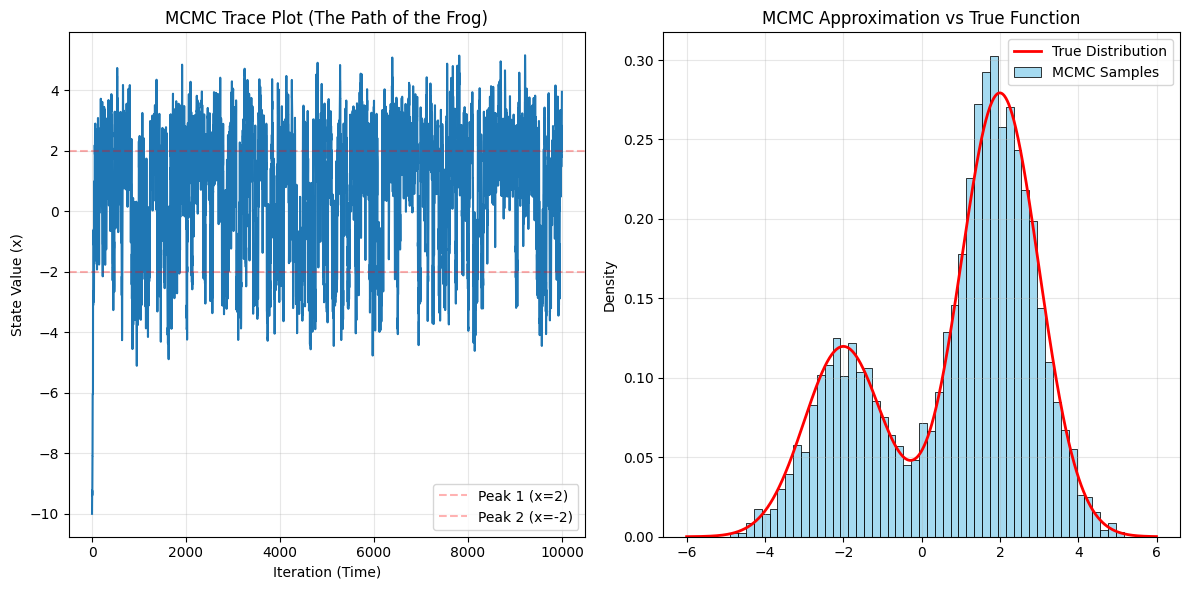

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. 设定目标分布 P(x) (Target Distribution)
# ==========================================
# 我们想要采样的分布是一个混合高斯分布（双峰）
# 这是一个“非标准化”的概率密度，MCMC 的魔力在于我们不需要知道分母（归一化常数）
def target_distribution(x):
    # 两个山头：一个在 x=-2，一个在 x=2
    return 0.3 * np.exp(-0.5 * (x + 2)**2) + 0.7 * np.exp(-0.5 * (x - 2)**2)

# ==========================================
# 2. MCMC 采样器 (Metropolis-Hastings 算法)
# ==========================================
def run_mcmc(start_value, iterations):
    samples = [start_value]
    current_x = start_value
    
    # 记录一下被拒绝的次数，用于观察
    accepted_count = 0
    
    for i in range(iterations):
        # --- 步骤 A: 提议 (Proposal) ---
        # 基于当前位置 (Markov Property: 只依赖 current_x)
        # 向周围随机走一步（加高斯白噪声）
        proposal_x = current_x + np.random.normal(0, 1)
        
        # --- 步骤 B: 计算接受率 (Acceptance Ratio) ---
        # 核心推导：比值 = 目标处概率 / 当前处概率
        # 甚至不需要知道概率的具体值，只需要知道相对大小
        p_current = target_distribution(current_x)
        p_proposal = target_distribution(proposal_x)
        
        # 接受率 alpha = min(1, p_new / p_old)
        acceptance_ratio = min(1, p_proposal / p_current)
        
        # --- 步骤 C: 决定是否接受 (Decision) ---
        # 生成一个 0-1 的随机数，如果小于接受率就跳过去
        if np.random.rand() < acceptance_ratio:
            current_x = proposal_x # 状态转移
            accepted_count += 1
        else:
            current_x = current_x # 拒绝转移，保持原位（这也是一个采样！）
            
        # 记录当前状态
        samples.append(current_x)
        
    print(f"接受率: {accepted_count / iterations:.2%}")
    return np.array(samples)

# ==========================================
# 3. 运行模拟与可视化
# ==========================================

# 初始状态：从一个很偏僻的地方开始，比如 x = -10
# 这展示了马尔可夫链如何被吸引到高概率区域
start_x = -10
num_samples = 10000

# 运行 MCMC
chain = run_mcmc(start_x, num_samples)

# 绘制结果
plt.figure(figsize=(12, 6))

# 图 1: 采样轨迹 (Trace Plot)
# 展示马尔可夫链的游走路径
plt.subplot(1, 2, 1)
plt.plot(chain)
plt.title("MCMC Trace Plot (The Path of the Frog)")
plt.xlabel("Iteration (Time)")
plt.ylabel("State Value (x)")
plt.axhline(y=2, color='r', linestyle='--', alpha=0.3, label='Peak 1 (x=2)')
plt.axhline(y=-2, color='r', linestyle='--', alpha=0.3, label='Peak 2 (x=-2)')
plt.legend()
plt.grid(alpha=0.3)

# 图 2: 采样分布 vs 真实分布
plt.subplot(1, 2, 2)

# 绘制我们采样得到的直方图
sns.histplot(chain[1000:], bins=50, stat="density", label="MCMC Samples", color="skyblue") 
# 注意：chain[1000:] 是为了去掉"预热期"(Burn-in)，
# 因为从 -10 走到中心区域需要时间，前面的样本不准。

# 绘制真实的数学曲线
x_range = np.linspace(-6, 6, 1000)
# 计算归一化常数 Z (近似) 以便对比
Z = np.sum(target_distribution(x_range)) * (x_range[1] - x_range[0])
plt.plot(x_range, target_distribution(x_range) / Z, 'r-', linewidth=2, label="True Distribution")

plt.title("MCMC Approximation vs True Function")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()